In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

df = pd.read_csv('../data_samples/data_jobs.csv')

# Data Cleaning
df['job_posted_date'] = pd.to_datetime(df['job_posted_date']).dt.normalize()

def take_list(str_list):
    if pd.notna(str_list):
        return literal_eval(str_list)
    return str_list

df['job_skills'] = df['job_skills'].apply(take_list)

df

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16,False,False,United States,NaN,NaN,NaN,Boehringer Ingelheim,NaN,NaN
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14,False,False,Mexico,NaN,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10,False,False,Germany,NaN,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04,True,False,United States,NaN,NaN,NaN,Southwest Research Institute,"[python, c++, java, matlab, aws, tensorflow, k...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07,False,False,Sudan,NaN,NaN,NaN,Kristina Daniel,"[bash, python, oracle, aws, ansible, puppet, j...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785736,Software Engineer,DevOps Engineer,Singapura,melalui Trabajo.org,Pekerjaan tetap,False,Singapore,2023-03-13,False,False,Singapore,NaN,NaN,NaN,CAREERSTAR INTERNATIONAL PTE. LTD.,"[bash, python, perl, linux, unix, kubernetes, ...","{'os': ['linux', 'unix'], 'other': ['kubernete..."
785737,Data Analyst,CRM Data Analyst,"Bad Rodach, Jerman",melalui BeBee Deutschland,Pekerjaan tetap,False,Germany,2023-03-12,False,False,Germany,NaN,NaN,NaN,HABA FAMILYGROUP,"[sas, sas, sql, excel]","{'analyst_tools': ['sas', 'excel'], 'programmi..."
785738,Business Analyst,Commercial Analyst - Start Now,Malaysia,melalui Ricebowl,Pekerjaan tetap,False,Malaysia,2023-03-12,False,False,Malaysia,NaN,NaN,NaN,Lendlease Corporation,"[powerpoint, excel]","{'analyst_tools': ['powerpoint', 'excel']}"
785739,Data Engineer,"Principal Associate, Data Engineer (Remote-Eli...","Newark, New Jersey, Amerika Serikat",melalui Recruit.net,Pekerjaan tetap,False,Sudan,2023-03-12,False,False,Sudan,NaN,NaN,NaN,Capital One,"[python, go, nosql, sql, mongo, shell, mysql, ...","{'cloud': ['aws', 'snowflake', 'azure', 'redsh..."


In [4]:
# Filter the city you want
df_city = df[df['job_country'] == 'United States'].reset_index(drop=True)

In [11]:
# What are the skills most in demand for the top 3 most popular data roles ?
jobs = ['Data Analyst', 'Data Engineer', 'Data Scientist']
# First let's find the 3 most popular roles
most_popular = df_city[df_city['job_title_short'].isin(jobs)]['job_title_short'].value_counts().to_frame()


most_popular

,count
job_title_short,
Data Analyst,67816
Data Scientist,58830
Data Engineer,35080


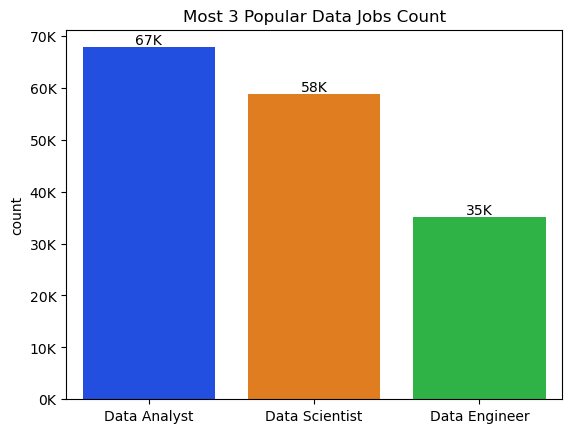

In [12]:
# Let's plot it
ax = sns.barplot(data=most_popular, x='job_title_short', y='count', hue='job_title_short', palette='bright')

ax.set_title('Most 3 Popular Data Jobs Count')
ax.set_xlabel('')

# Format the x-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1000)}K'))

# Format each label using a lambda
for c in ax.containers:
    ax.bar_label(
        c,
        labels=[f"{int(bar.get_height()/1000)}K" for bar in c]  # Custom formatting
    )


In [14]:
# Select the roles
df_jobs = df_city[df_city['job_title_short'].isin(jobs)].reset_index(drop=True)

# Explode
df_final = df_jobs.explode('job_skills')

In [16]:
def find_skills_for(df: pd.DataFrame, job: str, skills_count: int, ax: plt.Axes=None) -> pd.DataFrame:
    # Pivot
    pivoted = df[df['job_title_short'] == job].pivot_table(index='job_skills', aggfunc='size', sort=False)
    # Extract top 10 skills
    skills = pivoted.sort_values(ascending=False).head(skills_count).to_frame('Count')
    if ax is not None:
        sns.barplot(data=skills, x='Count', y='job_skills', ax=ax, hue='job_skills', palette='flare_r')
    else:
        ax = sns.barplot(data=skills, x='Count', y='job_skills', hue='job_skills', palette='flare_r')
    ax.set_ylabel('')
    ax.set_title(f'Top {skills_count} In-Demand Skills For {job} ')
    return skills


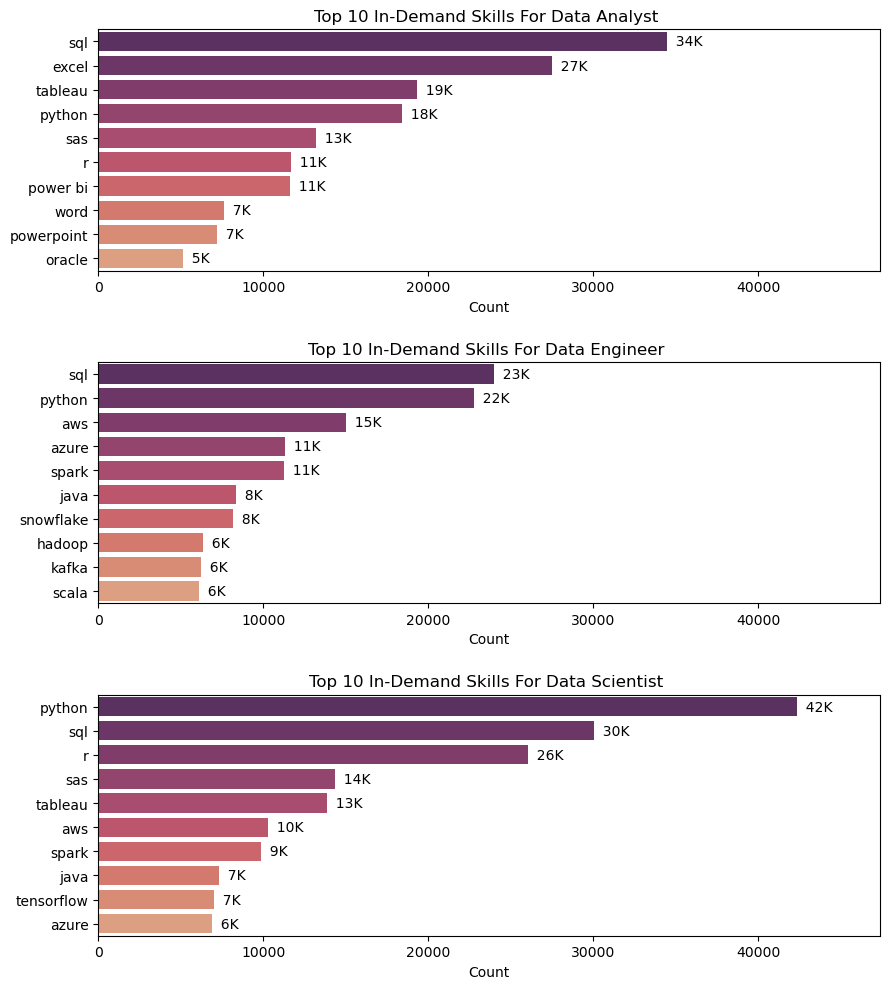

In [18]:
from typing import List

# Prepare the plots
fig, axs = plt.subplots(3, 1, figsize=(9, 10))

# To select the highest skills count to make plots the same x-axis values
skills_df:List[pd.DataFrame] = []

# Plot
for i, job in enumerate(jobs):
    skills_df.append(find_skills_for(df_final, job, 10, axs[i]))

max_skills_count = [skill['Count'].max() for skill in skills_df]

for ax in axs:
    # Fix the x-axis
    ax.set_xlim(0, max(max_skills_count) + 5000)
    # Add label for each bar
    for container in ax.containers:
        ax.bar_label(container, [f'  {int(bar.get_width() / 1000)}K' for bar in container])

# Fix the layout
fig.tight_layout(h_pad=2)



In [19]:
# To get the percentage we need to know how many jobs request we have
# For a certain job and then look for each skill how many times it
# Appeared there

def find_percentage_skills_for(df: pd.DataFrame, job: str, skills_count: int, total_jobs: int, ax: plt.Axes=None) -> pd.DataFrame:
    # Pivot
    pivoted = df[df['job_title_short'] == job].pivot_table(index='job_skills', aggfunc='size', sort=False)
    # Extract top 10 skills
    skills = pivoted.sort_values(ascending=False).head(skills_count).to_frame('Count')
    skills['Count'] = skills['Count'].apply(lambda num: round((num/total_jobs) * 100, 2))
    if ax is not None:
        sns.barplot(data=skills, x='Count', y='job_skills', ax=ax, hue='job_skills', palette='flare_r')
    else:
        ax = sns.barplot(data=skills, x='Count', y='job_skills', hue='job_skills', palette='flare_r')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Likelihood of Top {skills_count} In-Demand Skills For {job} ')
    ax.set_xlim(0, 80)
    
    # Add percentage
    for container in ax.containers:
        ax.bar_label(container, [f'  {bar.get_width()}%' for bar in container])
    
    return skills


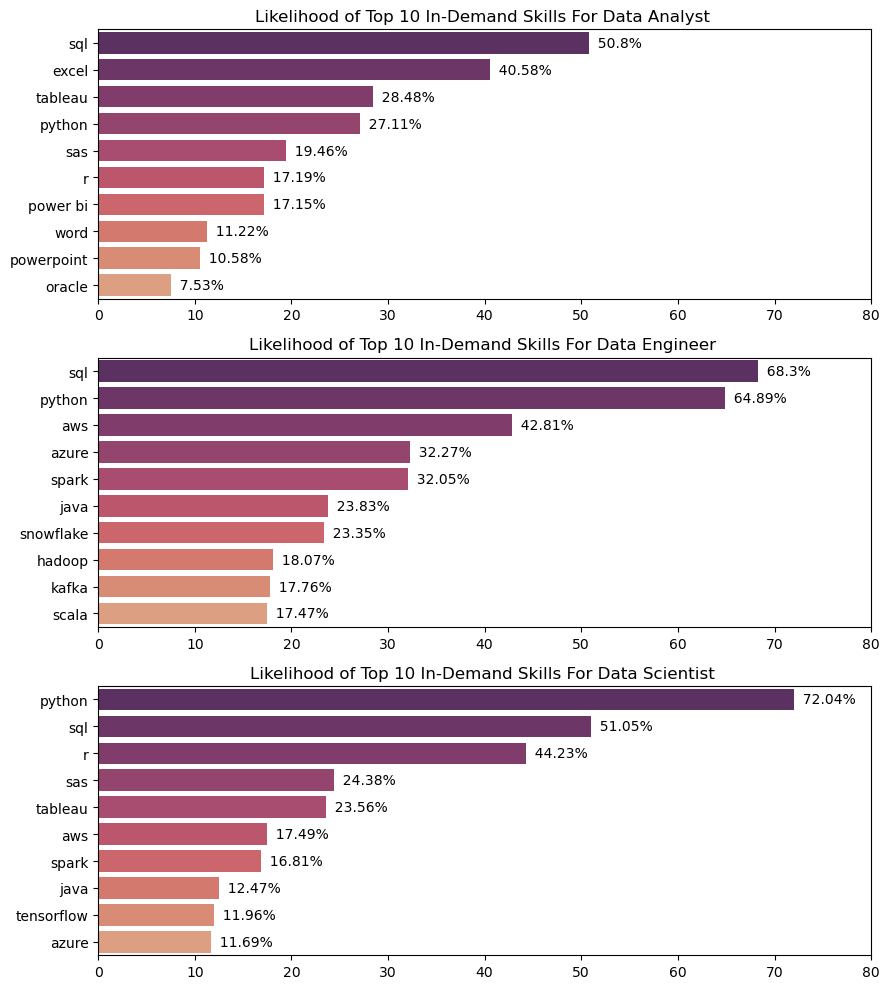

In [20]:
# Let's say the number of jobs per job title
# And look at (how many the skill X appeared in it)

# Prepare the plots
fig, axs = plt.subplots(3, 1, figsize=(9, 10))

# Plot
for i, job in enumerate(jobs):
    find_percentage_skills_for(df_final, job, 10, most_popular.loc[job]['count'], axs[i])

# Fix layout
fig.tight_layout(w_pad=4)
